# Stack Overflow questions

# Introduction

In this project, we will implement a tags recommendation system for *StackOverflow* questions.\
*StackOverflow* is a reknown platform for questions and answers about programmation.
* In the first notebook, we will extract the required data using the *StackExchange data explorer* tool, and explore the data.
* In the second notebook, we will implement various *machine learning algorithms* and select the suitable inference model to deploy an *API endpoint*.

# Environment

In [1]:
import pandas as pd
import numpy as np
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup as bs
import re
from IPython.display import Image
from wordcloud import WordCloud
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/grosjeanthibaud/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/grosjeanthibaud/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/grosjeanthibaud/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/grosjeanthibaud/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/grosjeanthibaud/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Data extraction

The StackExchange data explorer can be use to extract information from the SQL database:
https://data.stackexchange.com/stackoverflow/query/new \
Information about the database schema can be found at:
https://meta.stackexchange.com/questions/2677/database-schema-documentation-for-the-public-data-dump-and-sede

* We will extract the *Id*, *Title*, *Body*, and *Tags* from the *Posts* table
* We are working on questions, therefore, *TypeId* must be 1,
* We will generate 5 tags for each question, we therefore select posts with at least 5 *tags*,
* In order to select qualitative enouth posts, we select posts with a minimum *score* of 5,
* We order the extraction by *CreationDate*.

We used the following SQL request to obtain the .csv file from the *Exchange data explorer*:

**SELECT TOP(50000) Id, Title, Body, Tags\
From Posts\
WHERE PostTypeId = 1\
AND LEN(Tags) - LEN(REPLACE(Tags, '<','')) >= 5\
AND Score >= 5\
ORDER BY CreationDate**

We use pandas to load the extracted file:

In [2]:
df = pd.read_csv('./data/QueryResults.csv', index_col=0)

df.head()

,Title,Body,Tags
Id,,,
4,How to convert a Decimal to a Double in C#?,<p>I want to use a <code>Track-Bar</code> to c...,<c#><floating-point><type-conversion><double><...
11,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,<c#><datetime><time><datediff><relative-time-s...
13,Determine a user's timezone,<p>Is there a standard way for a web server to...,<html><browser><timezone><user-agent><timezone...
19,What is the fastest way to get the value of π?,<p>I'm looking for the fastest way to obtain t...,<performance><algorithm><language-agnostic><un...
25,How to use the C socket API in C++ on z/OS,<p>I'm having issues getting the C sockets API...,<c++><c><sockets><mainframe><zos>


# Data cleaning

In order to keep the most relevant information from the cleaned text, we make the following hypothesis:
* A question about programming is usually about how to program with something (a technology) to do something (a result), or how to optimize the code to do something,
* Therefore, the verbs and nouns must encapsulate most of the relevant information,
* In opposition to sentiment analysis, the adverbs are not that relevant.

Therefore, we have developped a pipeline to preprocess the data, for the question *content* (the *title* and *body*):
* The *Body* contains html code, we remove it using the *BeautifulSoup* library,
* We *tokenize* the text,
* We filter the text tokens using *POS tagging* in order to keep the verbs and nouns,
* We *lemmatize* the tokens to obtain the root words,
* We remove the *stop words*.

For the *tags*, which constitute our target *y*, we simply apply a *tokenization*.

The following schema sums up the applied transformations:

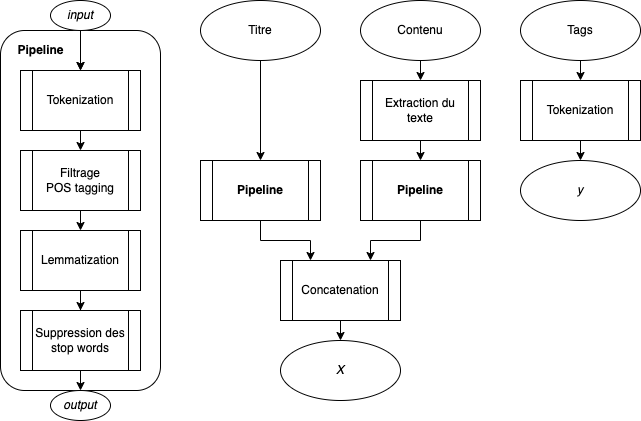

In [3]:
Image(filename='assets/preprocessing.png') 

We create functions to transform the raw data accordingly:

In [4]:
def remove_code(body):

    # Remove the code citations, which is the text between the <code> tags
    no_code = re.sub('<code>[^>]+</code>', '', body)
    # Parse with BeautifulSoup and keep the text only
    result = bs(no_code).get_text()

    return result

In [5]:
def process_text(text):

    # Convert the text to lower
    text = text.lower()
    # Tokenize the text
    tokens = word_tokenize(text, language='english')
    # Generate the pos tags
    tags = nltk.pos_tag(tokens)
    # Select the target pos tags
    pos_filter = ['NN', 'NNP', 'NNS', 'NNPS', 'VB']
    tokens = [token.replace('?', '') for token, pos in tags if pos in pos_filter]
    # Initialize the lemmatizer
    lemmatizer = WordNetLemmatizer()
    # Lemmatize the tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Remove the stop words
    tokens = [token for token in tokens if token not in stopwords.words('english')]
    # Format the result
    result = ','.join(tokens)

    return result

In [6]:
def tokenize_tags(tags):

    # Remove the start and end '>' and '<'
    stripped = tags.strip('<').strip('>')
    # Split the tags
    tokens = stripped.split('><')
    # tokens = [lemmatizer.lemmatize(token) for token in tokens] # We lemmatize the result
    # Format the output
    result = ','.join(tokens)

    return result

* We apply the tranformers on the datasets columns:

In [7]:
# First remove the code from the body
df['Body_tokens'] = df['Body'].apply(remove_code)
df['Body_tokens'] = df['Body_tokens'].apply(process_text)

df['Title_tokens'] = df['Title'].apply(process_text)

df['Tags_tokens'] = df['Tags'].apply(tokenize_tags)

df.head()

,Title,Body,Tags,Body_tokens,Title_tokens,Tags_tokens
Id,,,,,,
4,How to convert a Decimal to a Double in C#?,<p>I want to use a <code>Track-Bar</code> to c...,<c#><floating-point><type-conversion><double><...,"use,change,opacity,code,application,error,work...",convert,"c#,floating-point,type-conversion,double,decimal"
11,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,<c#><datetime><time><datediff><relative-time-s...,"value,display,time,hour,day,month","calculate,time","c#,datetime,time,datediff,relative-time-span"
13,Determine a user's timezone,<p>Is there a standard way for a web server to...,<html><browser><timezone><user-agent><timezone...,"way,web,server,determine,user,timezone,page,he...","determine,user,timezone","html,browser,timezone,user-agent,timezone-offset"
19,What is the fastest way to get the value of π?,<p>I'm looking for the fastest way to obtain t...,<performance><algorithm><language-agnostic><un...,"way,obtain,value,π,challenge,way,involve,const...","way,get,value,π","performance,algorithm,language-agnostic,unix,pi"
25,How to use the C socket API in C++ on z/OS,<p>I'm having issues getting the C sockets API...,<c++><c><sockets><mainframe><zos>,"issue,socket,work,c++,z/os,get,time,error,some...","use,c,socket,api,c++,z/os","c++,c,sockets,mainframe,zos"


# Concatenation

We concat the *Title* and *Body* tokens in order to form *X*, the data which will be used by the *machine learning* models to predict and suggest the *tags*:

In [8]:
df['Title_Body_tokens'] = df['Title_tokens'] + ',' + df['Body_tokens']

df.head()

,Title,Body,Tags,Body_tokens,Title_tokens,Tags_tokens,Title_Body_tokens
Id,,,,,,,
4,How to convert a Decimal to a Double in C#?,<p>I want to use a <code>Track-Bar</code> to c...,<c#><floating-point><type-conversion><double><...,"use,change,opacity,code,application,error,work...",convert,"c#,floating-point,type-conversion,double,decimal","convert,use,change,opacity,code,application,er..."
11,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,<c#><datetime><time><datediff><relative-time-s...,"value,display,time,hour,day,month","calculate,time","c#,datetime,time,datediff,relative-time-span","calculate,time,value,display,time,hour,day,month"
13,Determine a user's timezone,<p>Is there a standard way for a web server to...,<html><browser><timezone><user-agent><timezone...,"way,web,server,determine,user,timezone,page,he...","determine,user,timezone","html,browser,timezone,user-agent,timezone-offset","determine,user,timezone,way,web,server,determi..."
19,What is the fastest way to get the value of π?,<p>I'm looking for the fastest way to obtain t...,<performance><algorithm><language-agnostic><un...,"way,obtain,value,π,challenge,way,involve,const...","way,get,value,π","performance,algorithm,language-agnostic,unix,pi","way,get,value,π,way,obtain,value,π,challenge,w..."
25,How to use the C socket API in C++ on z/OS,<p>I'm having issues getting the C sockets API...,<c++><c><sockets><mainframe><zos>,"issue,socket,work,c++,z/os,get,time,error,some...","use,c,socket,api,c++,z/os","c++,c,sockets,mainframe,zos","use,c,socket,api,c++,z/os,issue,socket,work,c+..."


# Exploration

Now that we have preprocessed our data in order to keep the most relevant information, we will generate the terms frequencies in order to plot them:

In [9]:
def gen_frequencies(series):

    dist = FreqDist(','.join(series).split(','))

    return dist


title_body_frequencies = gen_frequencies(df['Title_Body_tokens'])

We first plot the word cloud for the questions *content* (*title* and *body*), a bigger word means that the term is more frequent:

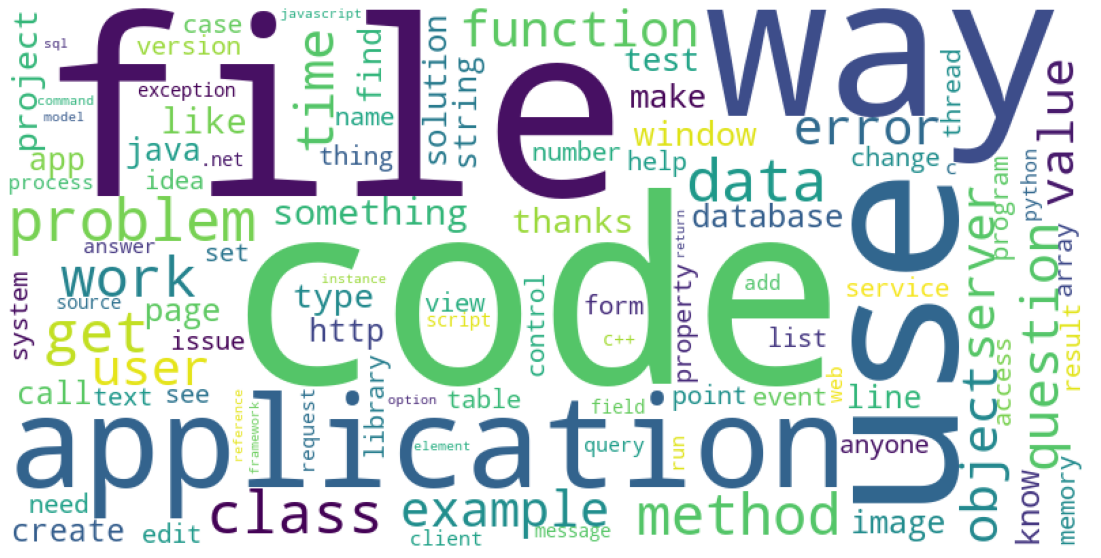

In [10]:
def word_cloud(frequencies):

    wordcloud = WordCloud(
        background_color='white',
        max_words=100,
        width=800,
        height=400
        ).generate_from_frequencies(frequencies)

    plt.figure(figsize=(20, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()


word_cloud(title_body_frequencies)

We plot the first most frequent terms and their frequencies:

In [11]:
def plot_frequencies(frequencies, name, top=10):

    uniques = len(frequencies)
    dist_df = pd.DataFrame({
        'Tag':frequencies.keys(),
        'Frequency':frequencies.values()}
        ).sort_values('Frequency').tail(top)

    fig = px.bar(
        dist_df,
        x='Frequency',
        y='Tag',
        orientation='h',
        title=f'Top {top} {name} frequencies, unique values: {uniques}',
        height=750)
    fig.show()


plot_frequencies(title_body_frequencies, 'Title & Body')

We do the same for the *tags*:

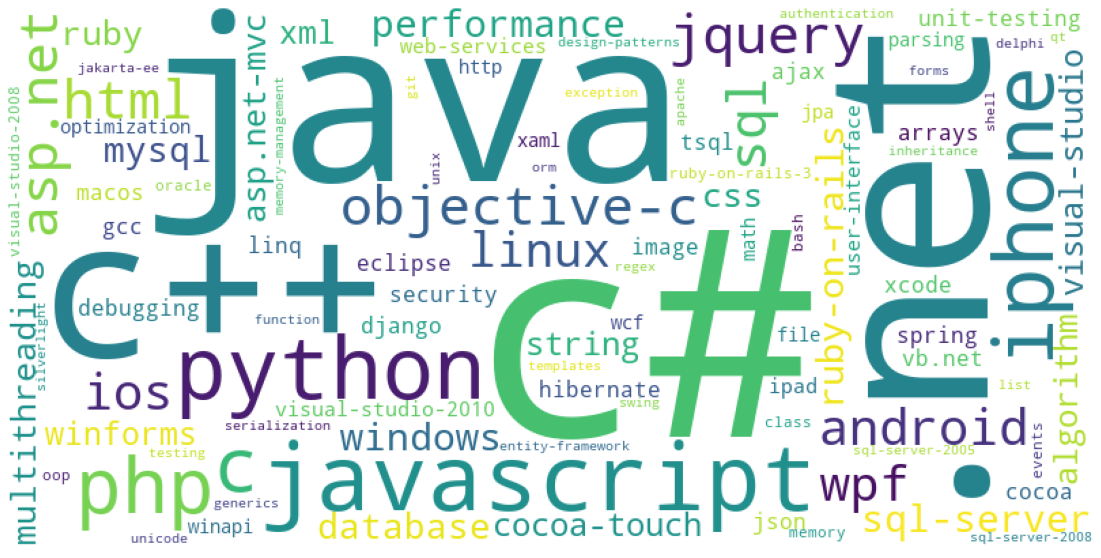

In [12]:
tags_frequencies = gen_frequencies(df['Tags_tokens'])
word_cloud(tags_frequencies)

In [13]:
plot_frequencies(tags_frequencies, 'Tags')

These visualizations already give us plenty of clues to understand the composition of our dataset.

# File Saving

*For further use*

In [14]:
df.to_csv('./data/df.csv')

# Conclusion

In this notebook, we have:
* Extracted the *StackOverflow* data using the *StackExchange data explorer* tool,
* Preprocessed the data,
* Vizualized the data

In the next notebook, we will process the data in order to train the *machine learning algorithms* to automatically suggest tags.